<a href="https://colab.research.google.com/drive/13HIS2dJCHglHV4AXPNkk546yEsX_rRMR?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Visualization using Datashader and cuDF

In this notebook, we'll be working with a NYC taxi trip data from January 2015 alone (as pre-processed and hosted at [pyviz.org](https://examples.pyviz.org/nyc_taxi)) -- corresponding to around 12 million trips overall. This is a small subset of the overall taxi dataset, but we'll see that even this becomes unwieldy to plot point data for. Here, we'll introduce a scalable workflow for better plotting point data using Datashader on GPUs. Note that this notebook is intended to be run on Google Colab or some other GPU-backed notebook session.

*Credit: adapted from [Holoviz Tutorial, KDD 2022](https://colab.research.google.com/github/holoviz-community/HoloViz_KDD2022/blob/main/03_Big_Data_Visualization.ipynb#scrollTo=196518af)*

## Import and configure packages

In [ ]:
!pip install panel hvplot datashader -- quiet
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py > /dev/null

In [2]:
import colorcet as cc
import matplotlib.pyplot as plt
import cudf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read in data

In [3]:
df_dev = cudf.read_parquet('https://s3.amazonaws.com/datashader-data/nyc_taxi_wide.parq',
                           columns=['dropoff_x', 'dropoff_y'])
df_dev.head()

,dropoff_x,dropoff_y
0,-8234835.5,4975627.0
1,-8237020.5,4976875.0
2,-8232279.0,4986477.0
3,-8238124.0,4971127.0
4,-8238107.5,4974457.0


Throughout the course, we've been using standard tools for plotting the output of our analyses. In order to utilize these libraries, though, we've always performed some sort of downsampling operations, so that we can get a sense of the distribution of points without running into memory issues (or rendering our plot unreadable).

However, if we take a look at the pickup locations in this dataset with even 10% of the overall dataset, note that we still can't see or interpret most of the points. It also takes some time to plot since we're still plotting over a million data points!

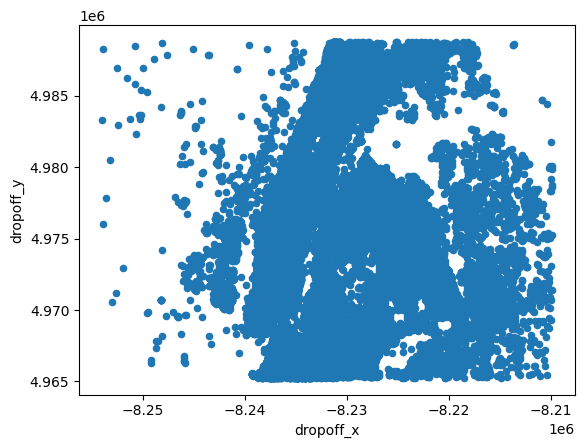

In [4]:
df_10p = df_dev.sample(frac=0.1) \
               .to_pandas()

df_10p.plot.scatter('dropoff_x', 'dropoff_y');

In fact, we only can begin to see/interpret points at small fractions of a percent:

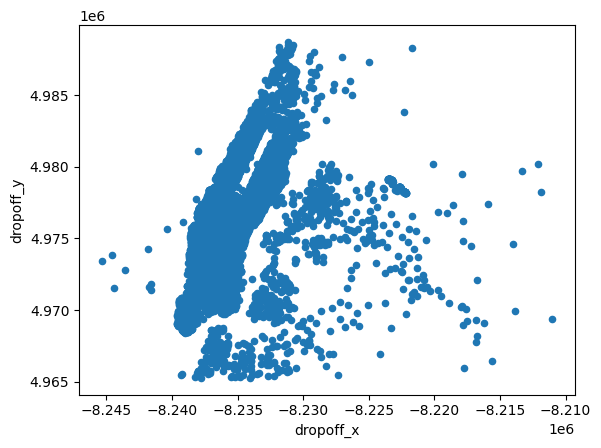

In [5]:
df_01p = df_dev.sample(frac=0.001) \
      .to_pandas()

df_01p.plot.scatter('dropoff_x', 'dropoff_y');

When we're sampling and/or subsetting our data, though, we're still not able to see all of it at once and interpret general patterns. For instance, within Manhattan, where is the highest density of passenger dropoffs? Currently, we just see a blob of points throughout. We could try to display all of our data and play around with the size/transparency settings of our data points to address this question, but for large data size (e.g. over 1 million data points), this will result in slow execution for `matplotlib` static plots (and potentially running out of memory).

One solution to this problem is to use [`datashader`](https://datashader.org/getting_started/Pipeline.html).

## How does Datashader work?

DataShader transforms our entire plot into an image, where each pixel is computed by aggregating together the points that correspond to a given location by a common metric. Better yet, it performs these pixel-level calculations in parallel. For instance, on GPUs, it uses packages like `cudf` to distribute shading tasks. These images are consequently smaller, but help to better communicate the general patterns inherent in our large dataset. Also, while the example today is based on point data (e.g. a scatter plot), datashader provides similar functionality for [line and polygon data](https://datashader.org/user_guide/Polygons.html), [time series](https://datashader.org/user_guide/Timeseries.html), as well as [network data](https://datashader.org/user_guide/Networks.html).

![](https://github.com/holoviz-community/HoloViz_KDD2022/blob/main/assets/datashader_pipeline.png?raw=1)

Datashader turns your data into a plot using a five-step pipeline. The Datashader docs illustrate how the pipeline works in each of the steps — projection, aggregation, transformation, colormapping, and embedding.

Let's first import Datashader so we can run through the individual steps:


In [6]:
import datashader as ds
import datashader.transfer_functions as tf

## Projection

First, we define a 2D canvas with width and height for the data to be projected onto. The canvas defines how many pixels we would like to see in the final image, and optionally defines the x_range and y_range that will map to these pixels. Here the data ranges to plot are not set in the Canvas, so they will be filled in automatically in the next step from the max and min of the data x and y values in the dataframe. The canvas defines what the projection will be, but for speed each point is actually projected during the aggregation step.

In [7]:
canvas = ds.Canvas(plot_width=900, plot_height=480)
canvas

## Aggregation

After we define the projected canvas, we project each point into the two-dimensional output grid and aggregate the results per pixel. Datashader supports many options for such aggregation, but in this example, we simply count how many data points are projected into each pixel, by iterating through the data points and incrementing the pixel where that point lands. The result in this case is a two-dimensional histogram counting dropoffs per pixel:

In [8]:
pixels = canvas.points(df_dev, 'dropoff_x', 'dropoff_y', agg=ds.count())
pixels

<xarray.DataArray (dropoff_y: 480, dropoff_x: 900)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * dropoff_x  (dropoff_x) float64 -8.254e+06 -8.254e+06 ... -8.21e+06 -8.21e+06
  * dropoff_y  (dropoff_y) float64 4.965e+06 4.965e+06 ... 4.989e+06 4.989e+06
Attributes:
    x_range:  (-8254332.0, -8209813.5)
    y_range:  (4965255.5, 4988769.5)

## Colormapping

Next, we can render the binned grid data to the corresponding pixels of an image. Each bin value is mapped into one of the 256 colors defined in a colormap, either by linear interpolation or with an automatic transformation (e.g. by calling the log function on each value, or as here using histogram equalization).

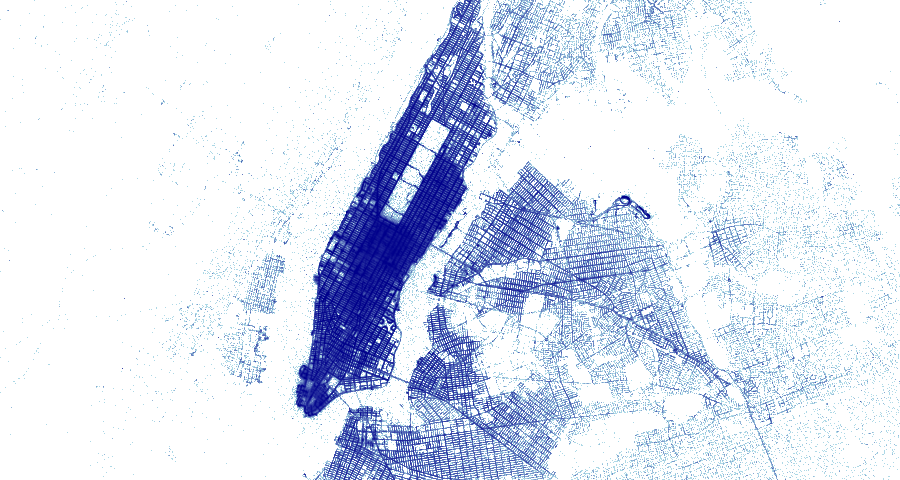

In [9]:
shaded = tf.shade(pixels)
shaded

We can also swap our color map to better visualize patterns. Here we’re using the “fire” colormap from Colorcet, which starts at black for the lowest counts (1 and 2 dropoffs) and goes through red for higher values (in the hundreds) and then yellow for even higher values (in the thousands) and finally white for the highest counts per pixel (in the tens of thousands in this case). We set the background to black to better visualize the data.

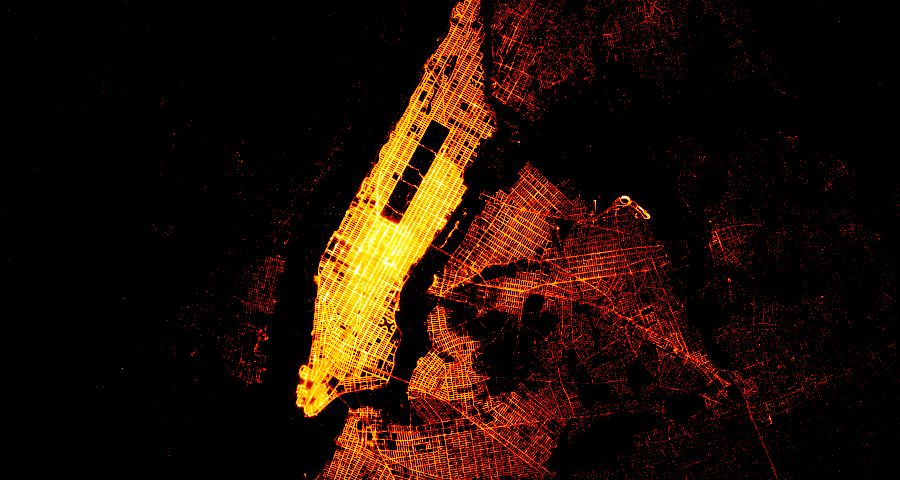

In [10]:
shaded_fire = tf.set_background(tf.shade(pixels, cmap=cc.fire), 'black')
shaded_fire

## Embedding

Finally, we can embed our shaded image into a plot with axes, titles, color bars, etc.:

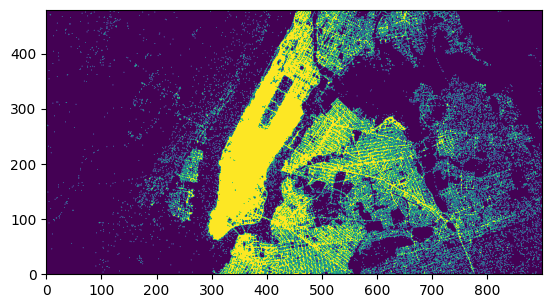

In [37]:
plt.imshow(shaded, origin='lower', cmap='viridis');

Alright that's it for now; I'd encourage you to read the `datashader` documentation for additional use-cases of the library (such as datashading large networks and time series) that might be relevant for your own research.